In [1]:
import os
import itertools
import matplotlib.pyplot as plt
import pandas as pd 
import pvlib
import numpy as np
from pvlib import clearsky, atmosphere, solarposition
from pvlib.location import Location
from pvlib import tracking
from pvlib.bifacial.pvfactors import pvfactors_timeseries
from pvlib import temperature
from pvlib.pvsystem import PVSystem, FixedMount
from pvlib.location import Location
from pvlib.modelchain import ModelChain
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS


from pvlib.iotools import read_tmy3
from matplotlib import rcParams


rcParams['figure.figsize'] = 20, 6
rcParams['lines.linewidth'] = 2.5

/Users/yaizabermudez/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [5]:
df_prod = pd.read_csv("/Users/yaizabermudez/internship/data_stage/Merged_2020-2022_weather_data.csv")
df_prod

,DateHeure,Valeur_HUMIDITY,Valeur_GLOBAL_RADIANCE,Valeur_TEMPERATURE,Prod. Photovoltaique (kWh),Rayonnement (W/m2)
0,2020-01-01 00:00:00,90.7,0.0,1.937,0.0,6.236033
1,2020-01-01 01:00:00,90.5,0.0,1.695,0.0,6.184950
2,2020-01-01 02:00:00,91.7,0.0,1.117,0.0,6.211167
3,2020-01-01 03:00:00,93.2,0.0,0.599,0.0,6.105450
4,2020-01-01 04:00:00,94.3,0.0,0.231,0.0,6.158800
...,...,...,...,...,...,...
26299,2022-12-31 19:00:00,79.9,0.0,13.000,0.0,0.000000
26300,2022-12-31 20:00:00,79.5,0.0,13.100,0.0,0.000000
26301,2022-12-31 21:00:00,79.5,0.0,13.400,0.0,0.000000
26302,2022-12-31 22:00:00,80.5,0.0,13.400,0.0,0.000000


In [6]:
df_prod['DateHeure'] = pd.to_datetime(df_prod.DateHeure, format ='%Y-%m-%d %H:%M:%S') 
df_prod.set_index('DateHeure', inplace=True)
df_prod.sort_index(inplace=True)
df_floor = df_prod['Prod. Photovoltaique (kWh)']

In [7]:
data_frame_floor = df_floor.copy()


## Physical model

In [8]:
lat = 45.20 # Latitude Grenoble
lon = 5.70 # Longitude Grenoble
tz = 'Etc/GMT+2'
altitude = 212


In [9]:
start = '2020-01-01'
end = '2022-12-31 23:00:00'

data_frame_floor = data_frame_floor.loc[data_frame_floor.index <= end]
data_frame_floor = data_frame_floor.loc[data_frame_floor.index >= start]
real  = data_frame_floor.values

times = pd.date_range(start, end, freq='1H', tz=tz)

In [10]:


def physical_val(lat=45.20, lon=5.7, altitude=212, tz='Etc/GMT+2', times = times):

    # create location object and get clearsky data
    site_location = Location(lat, lon,  tz=tz, altitude = altitude, name='Grenoble')

    #compute solar position trough times 
    solar_position = site_location.get_solarposition(times)

    # Compute absolute airmass
    airmass_relative  = pvlib.atmosphere.get_relative_airmass(solar_position['zenith'])
    airmass_absolute = pvlib.atmosphere.get_absolute_airmass(airmass_relative)

    # Compute aoi
    incidence_angle = pvlib.irradiance.aoi(surface_tilt=10, surface_azimuth= 90, solar_zenith= solar_position['zenith'], 
                            solar_azimuth= solar_position['azimuth'])
    
    return solar_position,airmass_relative, airmass_absolute, incidence_angle, site_location





In [11]:
s_position, airmass_r, airmass_a, angle, location = physical_val()

In [12]:
def calcule_pred(model_clear_sky, solar_position, airmass_absolute, incidence_angle, site_location, power=183, model_irrad = 'haydavies', tilt=6, angle=139): 
    # cs = site_location.get_clearsky(times)
    module = pvlib.pvsystem.retrieve_sam('SandiaMod')['Schott_Solar_ASE_300_DGF_50__320___2007__E__']
    cec_inverters = pvlib.pvsystem.retrieve_sam('cecinverter')['ABB__MICRO_0_25_I_OUTD_US_208__208V_']

    temperature_model_parameters = TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
    
    sapm_system = PVSystem(
    surface_tilt= tilt, 
    surface_azimuth= angle,
    module_parameters=module,
    inverter_parameters=cec_inverters,
    temperature_model_parameters=temperature_model_parameters)
    # print(sapm_system)
    
    irradiance = PVSystem.get_irradiance(sapm_system, solar_position['zenith'], solar_position['azimuth'], model_clear_sky['dni'], model_clear_sky['ghi'], model_clear_sky['dhi'], model=model_irrad)

   
    # Compute effective irradiance
    effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(irradiance['poa_direct'], irradiance['poa_diffuse'], airmass_absolute, 
                                                  incidence_angle, module )

    # celltemp = pvlib.pvsystem.sapm_celltemp(irradiance['poa_direct'], wind, temperature)
    m_pow = (module["Impo"] * module["Vmpo"]) 
    
    df_pred=solar_position.copy()

    pv_produced = pvlib.pvsystem.sapm(effective_irradiance, 25, module)
    pv_produced ["p_mp"] = (pv_produced ["p_mp"]* power)/(m_pow/1000) 

    pv_produced ["p_mp"] /=1000  # kWh

    df_pred['power'] = pv_produced['p_mp']

    df_pred = df_pred.loc[df_pred.index >= start]
    df_pred = df_pred.loc[df_pred.index <= end]
    df_pred = df_pred['power']
    

    return df_pred

First model using ineichen for clearsky

In [13]:
linke_turbidity = pvlib.clearsky.lookup_linke_turbidity(times, lat, lon, filepath=None, interp_turbidity=True)

In [14]:
model_ineichen= pvlib.clearsky.ineichen(s_position['apparent_zenith'], airmass_a, linke_turbidity, altitude=212, dni_extra=1364.0, perez_enhancement=False)

In [15]:
df_pred = calcule_pred(model_ineichen, s_position, airmass_a, angle, location,power=20, model_irrad = 'haydavies', tilt=10, angle=90  )
pred = df_pred.values

In [16]:
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import r2_score as APE
testScore = np.sqrt(MSE(real, pred))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/real.max())
test_mae = MAE(real, pred) 
print("MAE : ",test_mae)
test_mape = MAPE(real, pred) 
print("MAPE : ",test_mape)
test_ape = APE(real, pred) 
print("R2 : ",test_ape)

# real.max()

Test Score: 6.52 RMSE
RMSE en % :  33.450786192610764
MAE :  4.056205599984776
MAPE :  7089246043251503.0
R2 :  -1.7339529226028807


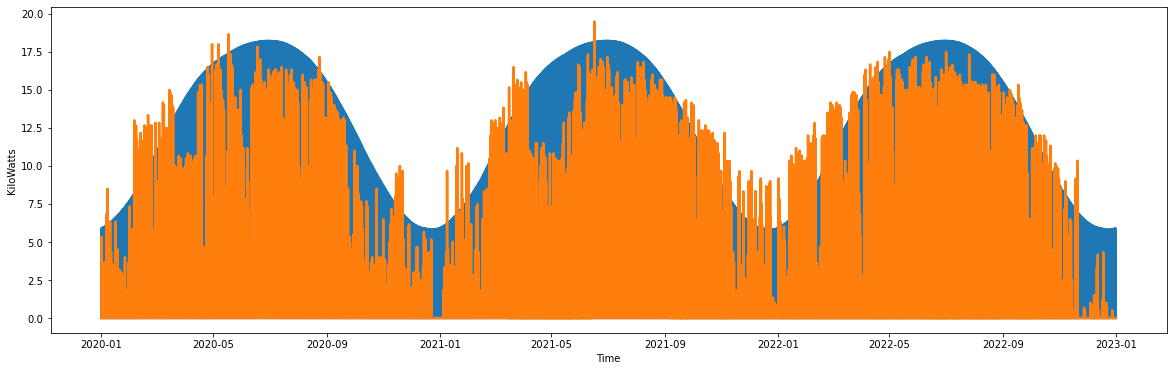

In [17]:
plt.plot(df_pred)
plt.plot(data_frame_floor)
plt.ylabel('KiloWatts')
plt.xlabel("Time")
plt.show()

avec perez irrad model

In [18]:
model_irradiance = 'perez'

In [19]:
df_pred = calcule_pred(model_ineichen, s_position, airmass_a, angle, location, power=20, model_irrad = model_irradiance, tilt=10, angle=90 )
pred = df_pred.values

In [20]:
testScore = np.sqrt(MSE(real, pred))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/real.max())
test_mae = MAE(real, pred) 
print("MAE : ",test_mae)
test_mape = MAPE(real, pred) 
print("MAPE : ",test_mape)
test_ape = APE(real, pred) 
print("R2 : ",test_ape)

Test Score: 6.57 RMSE
RMSE en % :  33.66675458090918
MAE :  4.0869571215961065
MAPE :  7177738697031014.0
R2 :  -1.7693693374186963


In [21]:
model_irradiance = 'isotropic'

In [22]:
df_pred = calcule_pred(model_ineichen, s_position, airmass_a, angle, location, power=20, model_irrad = model_irradiance, tilt=10, angle=90 )
pred = df_pred.values

In [23]:

testScore = np.sqrt(MSE(real, pred))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/real.max())
test_mae = MAE(real, pred) 
print("MAE : ",test_mae)
test_mape = MAPE(real, pred) 
print("MAPE : ",test_mape)
test_ape = APE(real, pred) 
print("R2 : ",test_ape)

Test Score: 6.46 RMSE
RMSE en % :  33.153573917299354
MAE :  4.016894196910976
MAPE :  6985610152814111.0
R2 :  -1.6855860757324974


In [24]:
model_irradiance = 'klucher'

In [25]:
df_pred = calcule_pred(model_ineichen, s_position, airmass_a, angle, location,power=20, model_irrad= model_irradiance, tilt=10, angle=90  )
pred = df_pred.values

In [26]:

testScore = np.sqrt(MSE(real, pred))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/real.max())
test_mae = MAE(real, pred) 
print("MAE : ",test_mae)
test_mape = MAPE(real, pred) 
print("MAPE : ",test_mape)
test_ape = APE(real, pred) 
print("R2 : ",test_ape)

Test Score: 6.62 RMSE
RMSE en % :  33.93314850505002
MAE :  4.109171216192974
MAPE :  7246207827843594.0
R2 :  -1.8133689408002702


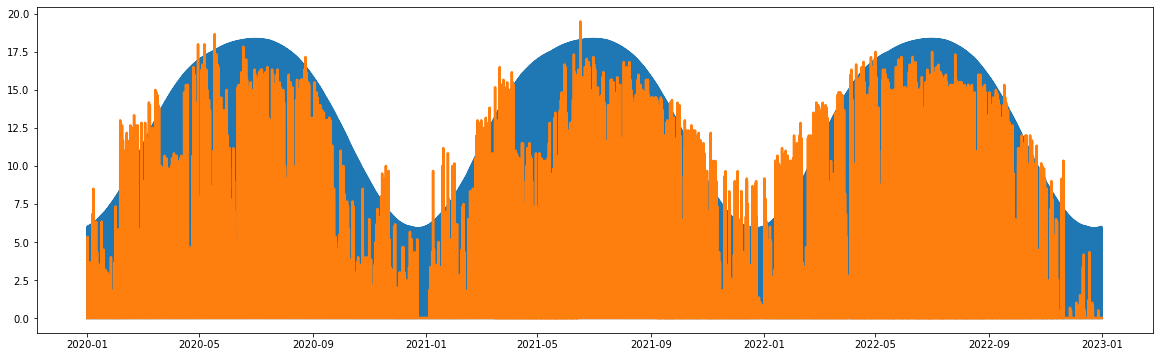

In [27]:
plt.plot(df_pred)
plt.plot(data_frame_floor)
plt.show()

Second model using simplified solis for clear sky

In [28]:
model_solis = pvlib.clearsky.simplified_solis(s_position['apparent_elevation'], aod700=0.1, precipitable_water=1.0, pressure=101325.0, dni_extra=1364.0)

In [29]:
df_pred = calcule_pred(model_solis, s_position, airmass_a, angle, location,power=20, model_irrad= model_irradiance, tilt=10, angle=90 )
pred = df_pred.values

In [30]:
testScore = np.sqrt(MSE(real, pred))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/real.max())
test_mae = MAE(real, pred) 
print("MAE : ",test_mae)
test_mape = MAPE(real, pred) 
print("MAPE : ",test_mape)
test_ape = APE(real, pred) 
print("R2 : ",test_ape)

Test Score: 7.21 RMSE
RMSE en % :  36.98673261602077
MAE :  4.520262522200935
MAPE :  8525934295300376.0
R2 :  -2.3424914769102094


In [31]:
model_irradiance = 'perez'

In [32]:
df_pred = calcule_pred(model_solis, s_position, airmass_a, angle, location,power=22, model_irrad= model_irradiance, tilt=10, angle=90 )
pred = df_pred.values

In [33]:
testScore = np.sqrt(MSE(real, pred))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/real.max())
test_mae = MAE(real, pred) 
print("MAE : ",test_mae)
test_mape = MAPE(real, pred) 
print("MAPE : ",test_mape)
test_ape = APE(real, pred) 
print("R2 : ",test_ape)

Test Score: 7.16 RMSE
RMSE en % :  36.729390006023635
MAE :  4.501210651092187
MAPE :  8474892743255375.0
R2 :  -2.296141175977176


In [34]:
model_irradiance = 'isotropic'

In [35]:
df_pred = calcule_pred(model_solis, s_position, airmass_a, angle, location,power=22, model_irrad= model_irradiance, tilt=10, angle=90 )
pred = df_pred.values

In [36]:

testScore = np.sqrt(MSE(real, pred))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/real.max())
test_mae = MAE(real, pred) 
print("MAE : ",test_mae)
test_mape = MAPE(real, pred) 
print("MAPE : ",test_mape)
test_ape = APE(real, pred) 
print("R2 : ",test_ape)

Test Score: 7.07 RMSE
RMSE en % :  36.25690852511389
MAE :  4.4327463463563035
MAPE :  8276932313320938.0
R2 :  -2.2118844648135028


In [37]:
model_irradiance = 'klucher'

In [38]:
df_pred = calcule_pred(model_solis, s_position, airmass_a, angle, location, power=22, model_irrad= model_irradiance, tilt=10, angle=90 )
pred = df_pred.values

In [39]:

testScore = np.sqrt(MSE(real, pred))
print('Test Score: %.2f RMSE' % (testScore))
print('RMSE en % : ', testScore*100/real.max())
test_mae = MAE(real, pred) 
print("MAE : ",test_mae)
test_mape = MAPE(real, pred) 
print("MAPE : ",test_mape)
test_ape = APE(real, pred) 
print("R2 : ",test_ape)

Test Score: 7.21 RMSE
RMSE en % :  36.98673261602077
MAE :  4.520262522200935
MAPE :  8525934295300376.0
R2 :  -2.3424914769102094


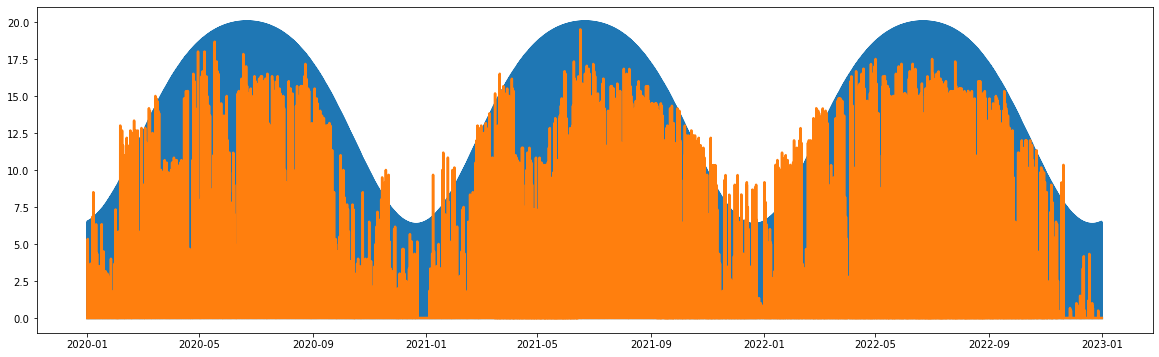

In [40]:
plt.plot(df_pred)
plt.plot(data_frame_floor)
plt.show()